## Part 2 - Neural Network Implementation for Image Segmentation

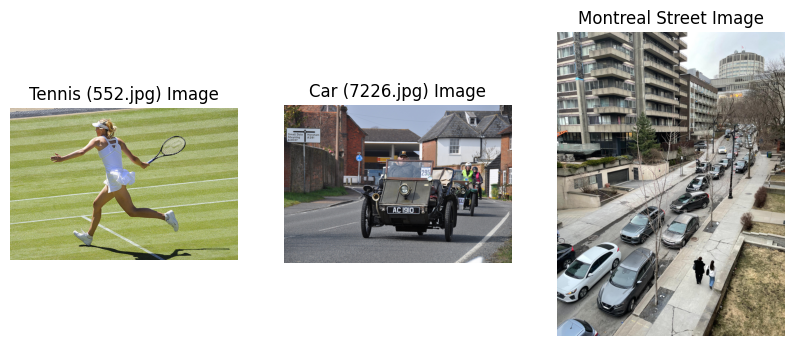

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import visualize
import torch
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn

# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline

# Load image Google Drive
# image_path = '/content/drive/My Drive/ECSE415_computer_vision/A5/'
image_path = r"C:\Users\theog\Documents\CodingProjects\ECSE415_Computer_Vision\Assignments\A5"
tennis_image = cv2.imread(image_path + r"\Part 2\000000000552.jpg")
car_image = cv2.imread(image_path + r"\Part 2\000000007226.jpg")
street_image = cv2.imread(image_path + r"\Part 2\image_street.jpg")

images = [tennis_image, car_image, street_image]
image_names = ['Tennis', 'Car', 'Montreal street']

# show images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(tennis_image, cv2.COLOR_BGR2RGB))
plt.title("Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))
plt.title("Car (7226.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(street_image, cv2.COLOR_BGR2RGB))
plt.title("Montreal Street Image")
plt.axis('off')
plt.show()


### 1. Implement the pre-trained Mask R-CNN and YOLOv8n-seg model and run them on the 552.jpg and 7726.jpg image included in the assignment folder.

In [2]:
#================= Pre-trained Mask R-CNN =================

# Load the pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

transform = T.Compose([T.ToTensor()])

# List to store the predictions
predictions = []

# Loop over the images and make the predictions
for image in images:
  # Convert the image to a tensor
  image_tensor = transform(image)
  # Get the model's prediction
  with torch.no_grad():
    prediction = model([image_tensor.to(torch.float32)])
  # Add the prediction to the list
  predictions.append(prediction)

# COCO_INSTANCE_CATEGORY_NAMES provided on the RCNN github
COCO_INSTANCE_CATEGORY_NAMES = [
  '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
  'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
  'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
  'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
  'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
  'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
  'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
  'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
  'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
  'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
  'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

C:\Users\theog\Documents\CodingProjects\ECSE415_Computer_Vision\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\theog\Documents\CodingProjects\ECSE415_Computer_Vision\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2. Display the result that shows the bounding boxes, object classes, and segmentations inside each bounding box.


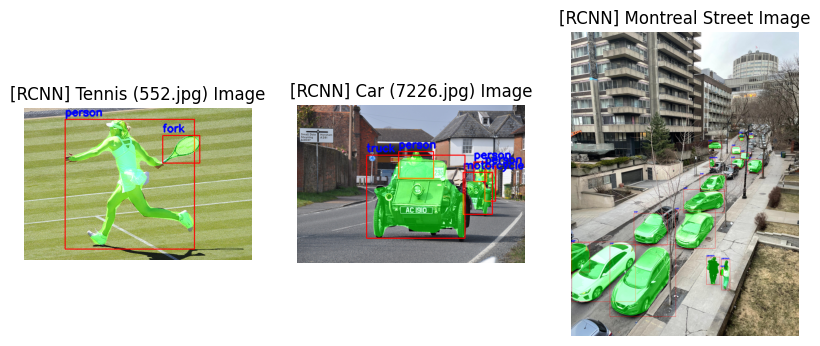

In [3]:
def create_mask(image, mask, color=(0, 255, 0)):
  mask = mask.mul(255).byte().cpu().numpy()
  color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  color_mask[mask > 128] = np.array(color, dtype=np.uint8)
  return cv2.addWeighted(image, 1, color_mask, 0.5, 0)

def draw_box(image, box, color=(0, 0, 255)):
  cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
  return image

def draw_label(image, box, label, color=(255, 0, 0)):
  cv2.putText(image, label, (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
  return image

def process_image_with_predictions(image, prediction, threshold=0.75):
  for element in range(len(prediction[0]['masks'])):
    mask = prediction[0]['masks'][element, 0]
    score = prediction[0]['scores'][element].item()
  
    if score > threshold:
      image = create_mask(image, mask)
      box = prediction[0]['boxes'][element].cpu().numpy()
      image = draw_box(image, box)
  
      label = prediction[0]['labels'][element].item()
      label_name = COCO_INSTANCE_CATEGORY_NAMES[label]
      image = draw_label(image, box, label_name)
  
  return image

labelled_tennis_image = process_image_with_predictions(tennis_image, predictions[0])
labelled_car_image = process_image_with_predictions(car_image, predictions[1])
labelled_street_image = process_image_with_predictions(street_image, predictions[2])


# show images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(labelled_tennis_image, cv2.COLOR_BGR2RGB))
plt.title("[RCNN] Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(labelled_car_image, cv2.COLOR_BGR2RGB))
plt.title("[RCNN] Car (7226.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(labelled_street_image, cv2.COLOR_BGR2RGB))
plt.title("[RCNN] Montreal Street Image")
plt.axis('off')
plt.show()

In [8]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
!pip install ultralytics
!pip install onnxruntime-gpu  # For GPU support
!pip install numpy
!pip install opencv-python

!yolo export model=yolov8s-seg.pt imgsz=640 format=onnx opset=12 simplify

# Load images
image_path = '/content/drive/My Drive/ECSE415_computer_vision/A5/'
street_image = cv2.imread(image_path + "Part 2/image_street.jpg")
tennis_image = cv2.imread(image_path + "Part 2/000000000552.jpg")
car_image = cv2.imread(image_path + "Part 2/000000007226.jpg")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ultralytics YOLOv8.1.41 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv8s-seg summary (fused): 195 layers, 11810560 parameters, 0 gradients, 42.6 GFLOPs

PyTorch: starting from 'yolov8s-seg.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 116, 8400), (1, 32, 160, 160)) (22.8 MB)

ONNX: starting export with onnx 1.16.0 opset 12...
ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 2.8s, saved as 'yolov8s-seg.onnx' (45.2 MB)

Export complete (6.1s)
Results saved to /content
Predict:         yolo predict task=segment model=yolov8s-seg.onnx imgsz=640  
Validate:        yolo val task=segment model=yolov8s-seg.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export



0: 448x640 1 person, 1 tennis racket, 402.6ms
Speed: 1.5ms preprocess, 402.6ms inference, 15.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 persons, 1 motorcycle, 38.2ms
Speed: 1.4ms preprocess, 38.2ms inference, 7.3ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 2 persons, 16 cars, 30.7ms
Speed: 5.4ms preprocess, 30.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 480)


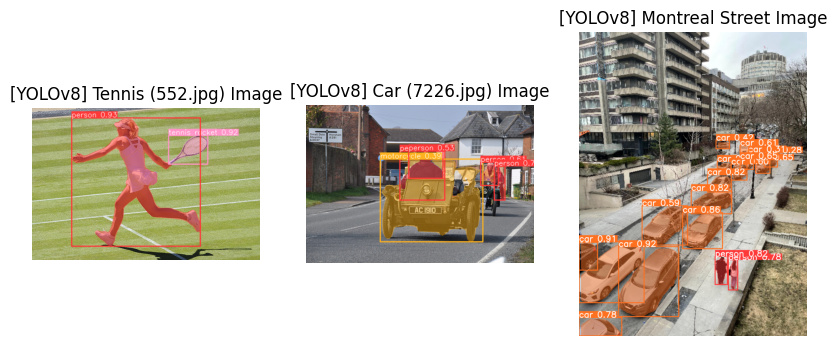

In [9]:
mages = [tennis_image, car_image, street_image]
# Load a pretrained YOLO model
model = YOLO('yolov8s-seg.pt')
detected_images=[]
for image in images:
  results = model.predict(image)
  result=results[0]
  detected_images.append(result.plot())

# Extract segemented images
detected_image_street = detected_images[2]
detected_image_car = detected_images[1]
detected_image_tennis = detected_images[0]

# show images next to each other:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(detected_image_tennis, cv2.COLOR_BGR2RGB))
plt.title("[YOLOv8] Tennis (552.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(detected_image_car, cv2.COLOR_BGR2RGB))
plt.title("[YOLOv8] Car (7226.jpg) Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(detected_image_street, cv2.COLOR_BGR2RGB))
plt.title("[YOLOv8] Montreal Street Image")
plt.axis('off')
plt.show()

### 4. Compare the performance of these two models and explain the steps that Mask R-CNN took to achieve the final result.


